# Analysis of Copenhagen Property Prices

Buying property in Denmark is not a simple process. Availability of property is never guaranteed, and prices largely depend on the type of property you are looking for and where it is located.
The vast majority of property in Copenhagen consists of flats and apartment blocks. Apartments on the ground floor are usually the cheapest, while those on higher floors tend to be more expensive. Apartments on the top floor tend to be the most popular even though a lot of the older apartment blocks in Copenhagen do not have a lift. However buying any apartment in Copenhagen, no matter which floor, is always going to be relatively expensive.

This analysis comes to complement my previous work of classifying Copenhagen stations based on the neighborhoods surrounding metro and train stations. My previous work is [here](https://www.linkedin.com/pulse/clustering-copenhagen-stations-anas-rezk/?trackingId=OlAAhSTFTSeaar07nU5laQ%3D%3D).


A brief recap of the results as follows:
-        Stations were grouped in 4 clusters.
-        Cluster 0 stations are at the outskirts of Copenhagen (underdeveloped areas) , cluster 1 stations are located in the oldest central part of the city (diversely developed part of the city), whereas cluster 2 (Professional & Other Places)and cluster 3 (Residence and College & University) are intermingled. They are also located in Copenhagen “downtown” surrounding cluster 1. Most of these stations have excellent transit accessibility and there are many colleges have their campuses around and small to medium size company.
 
# Target Audience
Through this article, I attempt to give potential property hunters an insight into the sqm price development in several communes in Copenhagen. Also, answer to top level questions, such as,
- which property type (house/flat) has the most significant price appreciation through the year in Copenhagen?
- which are the communes that witnessed the best appreciation rates?
- How did the communes’ urban development play on defining the property values?
 
# Data
1. Copenhagen Stations Clusters (Results from a previous work, “[Clustering of Copenhagen Stations](https://www.linkedin.com/pulse/clustering-copenhagen-stations-anas-rezk/?trackingId=OlAAhSTFTSeaar07nU5laQ%3D%3D)“)
2. Sales of Real Property (Statistics Denmark,  [Association of Danish Mortgage Banks](https://rkr.statbank.dk/statbank5a/SelectVarVal/Define.asp?MainTable=BM010&TabStrip=Select&PLanguage=1&FF=20)):  a dataset of real estate property's transaction price realized over the period 1992-2019. This data is given per commune. 
3. [Kortforsyningen Services API](https://kortforsyningen.dk/indhold/geonoegler-rest) offered by Danish Styrelsen for Dataforsyning og Effektivisering, I could find the communes (municipality) where stations are locat

# 1 Importing Libraries and Transport Datasets 

All libraries needed for the projects are imported in this steps.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.dates as dates
import matplotlib.dates as mdates

from datetime import datetime

from sklearn import linear_model

import itertools



print('Libraries imported.')

Libraries imported.


# 1 Data Processing 
## 1.1 Link Clusters to Communes
Let's import first the results from previous work and crunsh data a bit more. 

In [2]:
stations_venues_df = pd.read_csv('stations_venues_P.csv', index_col=0)

Using **kortforsyningen Services** API offered by Danish Styrelsen for Dataforsyning og Effektivisering, I could find the communes (municipality) where stations are located.

In [3]:
stations_venues_df.insert(1, 'Commune', 0)
for i in range(stations_venues_df.shape[0]):
    url='https://services.kortforsyningen.dk/?servicename=RestGeokeys_v2&method=kommune&geop={},{}&georef=EPSG:4326&token=cb599716a1d2127367853014fa7fa1e5'.format(stations_venues_df['Longitude'][i],stations_venues_df['Latitude'][i])
    results = requests.get(url).json()
    stations_venues_df.loc[i,'Commune'] = results['features'][0]['properties']['navn']
stations_venues_df.head()

,Station,Commune,Cluster Labels,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Aksel Moellers Have,Frederiksberg,Cluster 3,55.686051,12.532947,8,53,0,94,27,37,47,3,69,13
1,Amager Strand,København,Cluster 0,55.656135,12.631858,11,3,0,17,4,20,11,3,9,4
2,Amagerbro,København,Cluster 2,55.663396,12.602895,4,42,0,67,15,28,28,16,61,12
3,Bella Center,København,Cluster 2,55.638072,12.582932,4,3,0,34,5,11,43,4,73,11
4,Christianshavn,København,Cluster 3,55.672374,12.588578,49,14,0,139,73,63,52,16,63,54


As dataset of property price is available only per commune, I will assume going forward with this project that communes will inheret the cluster labels of the stations located in its area.

Some communes in Copenhagen have multiple train and metro stations. I remark also that communes have stations that belong to different clusters. For example, Copenhagen commune has stations that belong to clusters 0,1,2 and 3.

## 1.2 Proprety Price
Import property price csv file that I get from Danish StatBank and add it to a dataframe, process it.


In [4]:
#Transaction price realised
House_df = pd.read_csv('House Prices2.csv', encoding= 'unicode_escape', skiprows=2)

I cleaned the dataset and prepare it for further manipulation. 

In [5]:
House_df.rename(columns={House_df.columns[0]: "0",
                         House_df.columns[1]: "Property Type",
                         House_df.columns[2]: "Commune"}, inplace= True)

House_df.drop(columns="0", inplace= True)
House_df.drop(House_df.index[0], inplace= True)
for i in range(House_df.shape[0]):
    while House_df.iloc[i,0] == ' ':
        House_df.iloc[i,0]=housetype
    else:
        housetype=House_df.iloc[i,0]
House_df.drop([1,26,51],inplace= True)
House_df.reset_index(drop=True, inplace= True)
House_df.insert(2, 'Cluster', '')

## 1.3 Merge data
I collect the cluster information from stations_venues_df (previous work) dataframe and import its labels into the commune property price dataframe (House_df) by cross checking the communes columns. 

In [6]:
#create an empty dataframe 
inter=pd.DataFrame()

#add appropriate cluster labels to House_df and make a copy of the row, 
#one row per unique pair of commune and cluster label,  
#<in case of multiple clusters for a specific commune>  
for i in range(House_df.shape[0]):
        for RAM in range(stations_venues_df.shape[0]):
            Cluster=stations_venues_df.iloc[RAM,2]
            if House_df.iloc[i, 1]==stations_venues_df.iloc[RAM,1] or House_df.iloc[i, 1]=='Copenhagen':
                if Cluster == 'Cluster 0' and House_df.iloc[i,2]=='':
                    House_df.iloc[i,2]="Cluster 0"
                elif Cluster == 'Cluster 0' and House_df.iloc[i,2]!='' and House_df.iloc[i,2]!='Cluster 0':
                    inter=House_df.iloc[[i]]
                    inter.iloc[0,2]="Cluster 0"
                    House_df=House_df.append(inter, ignore_index=True)
                if Cluster == 'Cluster 1' and House_df.iloc[i,2]=='':
                    House_df.iloc[i,2]="Cluster 1"
                elif Cluster == 'Cluster 1' and House_df.iloc[i,2]!=''and House_df.iloc[i,2]!='Cluster 1':
                    inter=House_df.iloc[[i]]
                    inter.iloc[0,2]="Cluster 1"
                    House_df=House_df.append(inter, ignore_index=True)
                if Cluster == 'Cluster 2' and House_df.iloc[i,2]=='':
                    House_df.iloc[i,2]="Cluster 2"
                elif Cluster == 'Cluster 2'and House_df.iloc[i,2]!=''and House_df.iloc[i,2]!='Cluster 2':
                    inter=House_df.iloc[[i]]
                    inter.iloc[0,2]="Cluster 2"
                    House_df=House_df.append(inter, ignore_index=True)
                if Cluster == 'Cluster 3' and House_df.iloc[i,2]=='':
                    House_df.iloc[i,2]="Cluster 3"
                elif Cluster == 'Cluster 3' and House_df.iloc[i,2]!=''and House_df.iloc[i,2]!='Cluster 3':
                    inter=House_df.iloc[[i]]
                    inter.iloc[0,2]="Cluster 3"
                    House_df=House_df.append(inter, ignore_index=True)                


House_df=House_df.drop_duplicates() 
columns=House_df.columns[~House_df.columns.isin(['Cluster','Commune','Property Type'])]

#drop rows with holiday home as property type since mostly prices are zeros. 
House_df=House_df[House_df['Property Type']!= 'Holiday home']

#replacing unavailable quarterly datapoints with the mean of the row 
House_df.replace({'..': 0}, inplace= True) 
House_df[columns]=House_df[columns].astype(int)
House_df.replace(0,House_df.mean(axis=0),inplace=True)
House_df[columns]=House_df[columns].astype(int)
House_df.sort_values(by=['Property Type','Commune','Cluster'],inplace=True, ascending=True)
House_df.reset_index(drop=True, inplace= True)
House_df.head()

/Users/anasrezk/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/anasrezk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/anasrezk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

,Property Type,Commune,Cluster,1992Q1,1992Q2,1992Q3,1992Q4,1993Q1,1993Q2,1993Q3,1993Q4,1994Q1,1994Q2,1994Q3,1994Q4,1995Q1,1995Q2,1995Q3,1995Q4,1996Q1,1996Q2,1996Q3,1996Q4,1997Q1,1997Q2,1997Q3,1997Q4,1998Q1,1998Q2,1998Q3,1998Q4,1999Q1,1999Q2,1999Q3,1999Q4,2000Q1,2000Q2,2000Q3,2000Q4,2001Q1,2001Q2,2001Q3,2001Q4,2002Q1,2002Q2,2002Q3,2002Q4,2003Q1,2003Q2,2003Q3,2003Q4,2004Q1,2004Q2,2004Q3,2004Q4,2005Q1,2005Q2,2005Q3,2005Q4,2006Q1,2006Q2,2006Q3,2006Q4,2007Q1,2007Q2,2007Q3,2007Q4,2008Q1,2008Q2,2008Q3,2008Q4,2009Q1,2009Q2,2009Q3,2009Q4,2010Q1,2010Q2,2010Q3,2010Q4,2011Q1,2011Q2,2011Q3,2011Q4,2012Q1,2012Q2,2012Q3,2012Q4,2013Q1,2013Q2,2013Q3,2013Q4,2014Q1,2014Q2,2014Q3,2014Q4,2015Q1,2015Q2,2015Q3,2015Q4,2016Q1,2016Q2,2016Q3,2016Q4,2017Q1,2017Q2,2017Q3,2017Q4,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4
0,Detached/terraced house,Albertslund,Cluster 0,5240,5408,5417,5341,5130,4773,5746,5492,5616,5235,5475,5455,6318,6160,6197,6238,6571,6568,7248,7574,7718,8260,7797,8729,7602,9026,8272,8743,9179,9246,9845,9993,9927,10457,10544,9839,10922,10827,10269,10671,12012,11536,11341,12321,12304,12327,12633,12832,12319,12892,14062,14656,14912,16194,17382,17804,18667,20581,21372,21221,20732,20233,19054,18189,18770,18378,17984,16401,15775,15327,15478,15831,16499,16128,15860,17309,17045,16268,15363,15549,15404,15444,15830,15374,14771,16232,15041,15703,15412,16657,16212,16512,16617,17284,17749,17595,17802,18469,19612,18988,19830,20553,19403,19643,20223,20710,20666,21841,20454,21088,20045,20597
1,Detached/terraced house,Allerød,Cluster 0,5939,6144,5789,5900,5890,5456,6815,6365,6573,6519,6731,6399,6734,7154,7023,6846,7813,7980,8097,8523,8724,9073,9046,9213,9825,10410,9837,10912,10821,10543,11951,11198,11677,11976,11786,12197,13074,12709,13072,13746,13676,13562,13427,14727,13364,14898,14196,14832,14424,15485,15881,16155,16741,18410,20306,20947,21353,23556,25998,25415,25254,23053,24724,22944,22937,22076,20574,18559,17401,17100,18332,17919,19152,18757,20835,20390,18669,19819,18357,18183,17336,18256,18001,17137,18406,18282,18703,19237,18755,20054,19581,19359,18749,19427,20029,19924,21024,20726,20746,20778,21179,21758,22526,21315,21934,22770,22576,22853,23327,23280,23537,24213
2,Detached/terraced house,Ballerup,Cluster 0,5696,6015,5771,5203,5925,5647,5813,6163,6132,6292,6770,6474,6379,6803,7196,7006,7622,8094,7769,8400,8647,8596,9203,9286,9232,9989,9853,10473,10242,10724,11071,11092,10696,11131,12114,11476,12189,12152,12408,12431,13059,13035,13260,12755,12529,13374,12881,13194,14333,15000,15877,16584,16690,17763,20267,21326,22071,23498,24559,21869,23464,24011,23347,22465,21067,21310,20585,17216,17168,17277,17137,18867,17852,19766,19143,19853,20740,19407,18928,17961,17319,17055,19122,17787,17451,18638,19253,17828,16996,18745,19716,19917,19495,20457,21138,19692,21434,21811,21410,22152,22131,22655,22088,23272,23045,23848,23531,23291,24341,24292,24584,23927
3,Detached/terraced house,Brøndby,Cluster 0,5663,6501,5947,5846,4823,6205,6752,6263,6934,6414,6342,5963,6350,6671,6709,7133,7357,7416,6920,8378,7877,9331,9046,8872,9703,9457,10749,10770,10148,11235,10985,10603,10791,11640,11403,11172,11373,11651,12328,12842,12680,12802,13501,13162,12329,13389,13718,13349,13100,14494,15555,16397,16515,17474,19421,20873,21987,24701,23711,24287,22428,22484,20567,21766,19132,21214,19163,18290,17028,16143,16747,17001,17084,18105,18456,18519,17306,19196,17387,19431,16526,16568,15818,16400,17249,16345,17724,16245,18263,17751,18516,18488,18601,18717,19444,20466,21158,20900,21378,21419,20687,22329,21765,22261,22929,23537,22268,23873,24036,24445,24901,23988
4,Detached/terraced house,Copenhagen,Cluster 0,5355,5451,5374,5171,5068,5186,5609,5519,5503,5885,5621,5328,5675,5924,6014,6299,6764,6991,7210,7227,7670,8263,8234,8520,9201,9275,9606,9762,9925,10590,10479,11078,10637,11422,11737,12562,12419,13571,13713,13422,14159,14256,14364,14191,14333,15552,15222,15715,16139,16857,17269,18771,19501,21562,23821,25553,27206,27479,28366,29214,27942,27929,26836,25853,26852,26058,24502,22342,208

Having the House_df in *pivot table* will make it easier going forward with indexing and plotting the data. 

In [7]:
#create a pivot table 
House_df_pivot=pd.pivot_table(House_df, index=['Property Type','Cluster','Commune'])
#Transpose the pivot table
House_df_pivot_T=House_df_pivot.transpose()


Final data frame that we have and we will be using for the rest of the project look like this... 

In [8]:
House_df_pivot

1992Q1  1992Q2  1992Q3  \
Property Type           Cluster   Commune                                  
Detached/terraced house Cluster 0 Albertslund       5240    5408    5417   
                                  Allerød           5939    6144    5789   
                                  Ballerup          5696    6015    5771   
                                  Brøndby           5663    6501    5947   
                                  Copenhagen        5355    5451    5374   
                                  Egedal            5241    5654    5393   
                                  Frederiksberg     5183    5626    6980   
                                  Frederikssund     5020    4870    4586   
                                  Furesø            6256    6083    6501   
                                  Gentofte          6783    7378    7288   
                                  Gladsaxe          6157    6163    6374   
                                  Glostrup          5401    5106    4992   
                                  Greve             5402    5544    5686   
                                  Herlev            5949    6122    6841   
                                  Hillerød          4847    5632    5688   
                                  Hvidovre          5399    5772    5249   
                                  Høje-Taastrup     5156    5522    5438   
                                  Ishøj             5119    5240    5070   
                                  Køge              4822    5157    5185   
                                  Lyngby-Taarbæk    6937    6670    6400   
                                  Rudersdal         7295    7075    6677   
                                  Solrød            5441    5580    5172   
                                  Vallensbæk        7820    7737    7800   
                        Cluster 1 Copenhagen        5355    5451    5374   
                        Cluster 2 Copenhagen        5355    5451    5374   
                                  Frederiksberg     5183    5626    6980   
                                  Lyngby-Taarbæk    6937    6670    6400   
                                  Tårnby            5747    6003    6075   
                        Cluster 3 Copenhagen        5355    5451    5374   
                                  Frederiksberg     5183    5626    6980   
Owner-occupied flat     Cluster 0 Albertslund       7024    7154    7190   
                                  Allerød           8168    7249    6292   
                                  Ballerup          6704    5846    6774   
                                  Brøndby           6136    6964    6055   
                                  Copenhagen        5843    5935    5701   
                                  Egedal            6205    5607    5371   
                                  Frederiksberg     6529    6520    6386   
                                  Frederikssund     6407    5646    5743   
                                  Furesø            6315    7140    6630   
                                  Gentofte          7399    7402    7767   
                                  Gladsaxe          6942    6811    6825   
                                  Glostrup          8427    6863    5545   
                                  Greve             6447    7122    6954   
                                  Herlev            7483    7038    6054   
                                  Hillerød          6774    7738    6188   
                                  Hvidovre          7441    5518    5770   
                                  Høje-Taastrup     5954    5899    5964   
                                  Ishøj             5345    5298    4990   
                                  Køge              6012    6688    6691   
                                  Lyngby-Taarbæk    7986    7698    7869   
                                  Rudersdal         8420    8518    8508   
                      

# 2 Visualisation of Price Development

Using the pivot table that I obtained in previous section, I made 3 plots using a subset of data, in particular Detached/terraced house prices for communes in cluster 0. The 3 plots are the following:

1. Fig.1. Boxplot over [1992-2019] time range. 
2. In Fig.2., I zoom in part of Fig.1. to get a better visibility on data. I make a [2001-2004] boxplot.  
3. In Fig.3., a violin plot for [2007-2011].



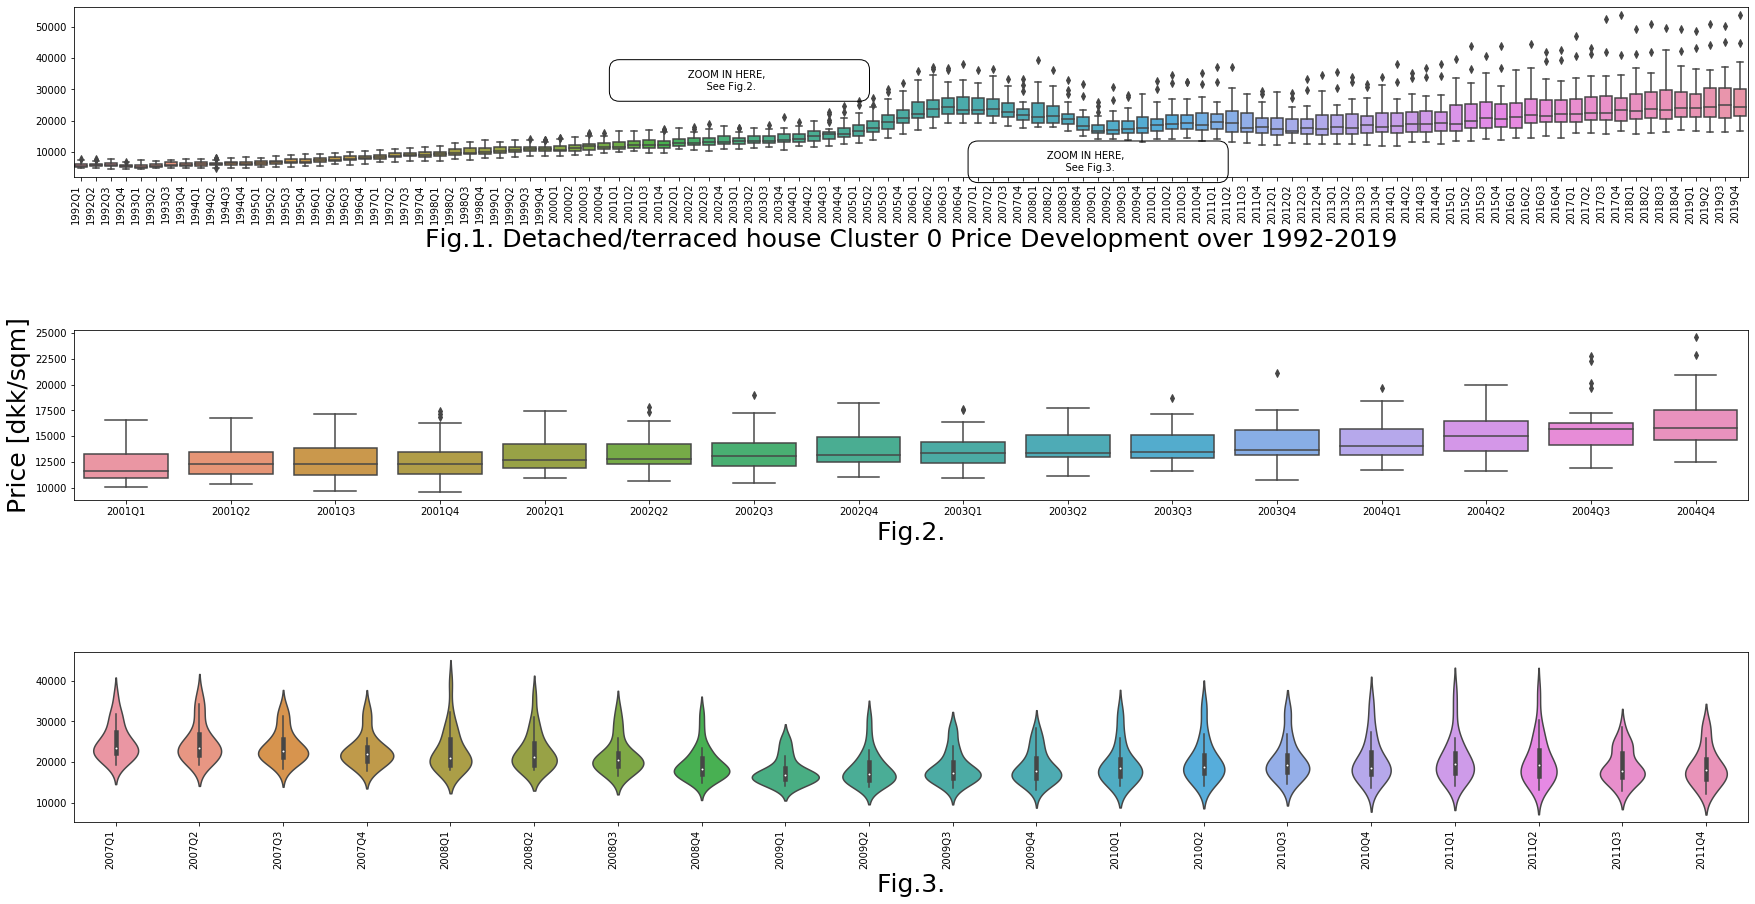

In [9]:
%matplotlib inline
#"height_ratios": (.9, .04),
grid_kws = {"hspace": .9}

f, (ax1, ax2, ax3) = plt.subplots(3, figsize=(30, 15), gridspec_kw=grid_kws)
#plt.figure(figsize=(20, 10))

ax1 = sns.boxplot(data=House_df_pivot.loc['Detached/terraced house','Cluster 0'], ax=ax1)
ax1.set_ylabel('', fontsize=25)
ax1.set_xlabel('Fig.1. Detached/terraced house Cluster 0 Price Development over 1992-2019', fontsize=25)
#ax1.set_title('Fig.1')
ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 90, ha="right")
ax1.text(36, 30000,
         '                      ZOOM IN HERE,                              \n                            See Fig.2.       ',
         color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))
ax1.text(60, 4000, 
         '                      ZOOM IN HERE,                              \n                            See Fig.3.       ',
         color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))

ax2 = sns.boxplot(data=House_df_pivot.loc['Detached/terraced house','Cluster 0'].iloc[:,36:52],  ax=ax2)
ax2.set_ylabel('Price [dkk/sqm]', fontsize=25)
ax2.set_xlabel('Fig.2.', fontsize=25) #Year [2001-2004]
#ax2.set_title('')
#ax2.set_xticklabels(ax2.get_xticklabels(),rotation = 45, ha="right")

ax3 = sns.violinplot(data=House_df_pivot.loc['Detached/terraced house','Cluster 0'].iloc[:,60:80],  showmeans=True,showmedians=True, ax=ax3)
ax3.set_ylabel('', fontsize=25)
ax3.set_xlabel('Fig.3.', fontsize=25) #Year [2007-2011]
#ax3.set_title('Fig.3')
ax3.set_xticklabels(ax3.get_xticklabels(),rotation = 90, ha="right")


plt.savefig('boxplots.jpg',bbox_inches='tight',dpi=100)


plt.show()


Sqaure meter prices for detached/terraced houses in cluster 0 (includes 23 communes) display a clear uptrend over 1992-2019. Houses in different communes have similar sqaure meter prices over the period (1992-2000). Their  Interquartile range (IQR) have a small size (less than ~1000 Dkk) the plots have few outliers and a small standard deviations. Median lines continues to ascend through year quarters with a constant rate till 2004 where increase rate has notably increased.  During this period [2004-2007], property prices in two communes witness a higher price increase and distinguish themself as outliers for the remaining of the period. 

Median hits a bottom around 16000dkk in 2nd quarter of 2009 then flactuates over 2 years, just to recover a rather constant increase rate.

As we can see also that data range, distance between whiskers exteremes (maximum-minimum), have steadly increase over time establishing and enforcing widening price gaps between commmunes.

Unimodal right-skewed probability distribution is clearly displayed in fig 3. Modes are located very close to the medians. Therefore, going forward, I will stick with medians as a representative datapoint for each cluster.




Going forward, I will use the **median** of the square meter price in the communes belonging to a specific cluster (applied vertically on year quarters). 


In [10]:
grouped=House_df.drop(columns=["Commune"])
#groupby clusters and took the median of the sample.
grouped=grouped.groupby(['Property Type',"Cluster"],as_index=False).median()              


In [11]:
H_pivoted=pd.pivot_table(grouped, index=['Property Type','Cluster'])

# 4.4 Property Price Heat Map


/Users/anasrezk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  del sys.path[0]
/Users/anasrezk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


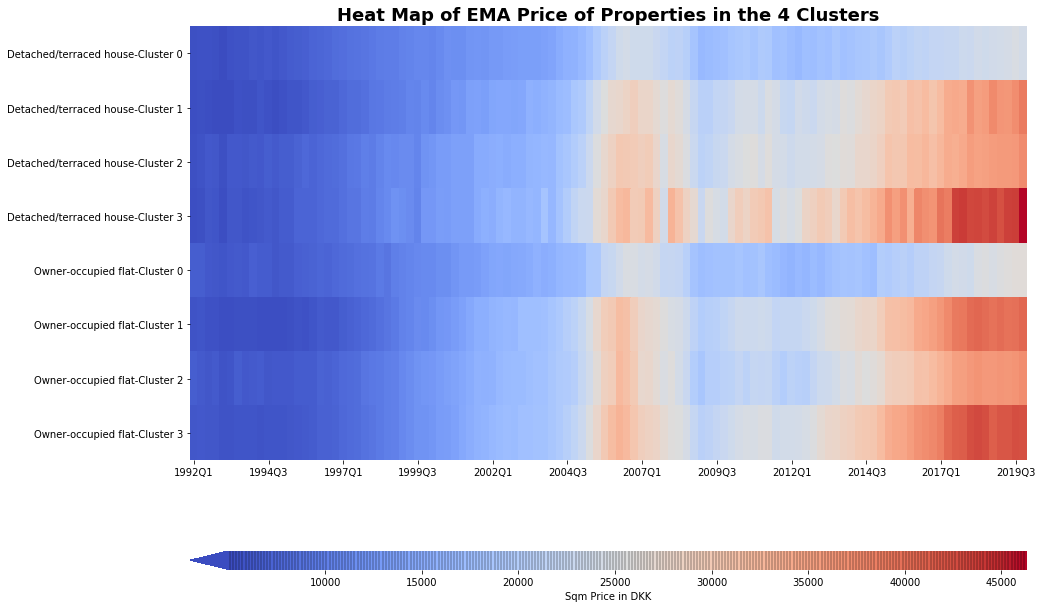

In [12]:
grid_kws = {"height_ratios": (.9, .04), "hspace": .4}

f, (ax, cbar_ax) = plt.subplots(2, figsize=(15, 10), gridspec_kw=grid_kws)
cbar_kws={"orientation": "horizontal","shrink":3,'extend':'min',"drawedges":True,'label': 'Sqm Price in DKK'}
sns.heatmap(H_pivoted, ax=ax, xticklabels=10, cmap="coolwarm", cbar_ax=cbar_ax, cbar_kws=cbar_kws)

ax.set(xlabel='', ylabel='')
ax.set_title('Heat Map of EMA Price of Properties in the 4 Clusters', fontsize= 18, weight='bold')

#ax.set_yticklabels({'weight': 'bold'})


f.tight_layout()
plt.savefig('heatmap.jpg',bbox_inches='tight',dpi=100)
f.show()



# 3 Further Data Wrangling
also, similar to the indicator used in stock market, I smooth out the price evolution using the **Exponential Moving Average (EMA)** that places a greater weight and significance on the most recent data points(applied horizontally on each row).

In [13]:
#make a seperate dataframe for the 4 clusters and find the EMA for each.
House_df_grouped0=grouped[grouped["Cluster"]=="Cluster 0"]    
House_df_grouped0=House_df_grouped0.drop(columns=["Cluster"])
House_df_grouped0.iloc[:,1:]=House_df_grouped0.iloc[:,1:].ewm(com=0.5).mean().astype(int)
House_df_grouped1=grouped[grouped["Cluster"]=="Cluster 1"] 
House_df_grouped1=House_df_grouped1.drop(columns=["Cluster"])
House_df_grouped1.iloc[:,1:]=House_df_grouped1.iloc[:,1:].ewm(com=0.5).mean().astype(int)
House_df_grouped2=grouped[grouped["Cluster"]=="Cluster 2"] 
House_df_grouped2=House_df_grouped2.drop(columns=["Cluster"])
House_df_grouped2.iloc[:,1:]=House_df_grouped2.iloc[:,1:].ewm(com=0.5).mean().astype(int)
House_df_grouped3=grouped[grouped["Cluster"]=="Cluster 3"] 
House_df_grouped3=House_df_grouped3.drop(columns=["Cluster"])
House_df_grouped3.iloc[:,1:]=House_df_grouped3.iloc[:,1:].ewm(com=0.5).mean().astype(int)

A change in time formate avaialable in the dataset (YYYYQQ) is necessary for regression work (coming up next). 
Here I have changed formate firstly to (YYYY-QQ) then convert it to a timestamp and later to a number and store results in CSV. files

In [14]:
grouped1=(House_df_grouped0,House_df_grouped1,House_df_grouped2,House_df_grouped3)

for count, group in enumerate(grouped1):
    RE=group.transpose()
    RE.columns=RE.iloc[0,:]
    RE.drop(['Property Type'], inplace= True)
    RE=RE.astype(int)
    qs1=RE.index  #index are immutable, I stored them in other variable, manipulate it and store it back to the index
    qs = qs1.str.replace(r'(\d+)(Q\d)', r'\1-\2')
    RE.index=qs
    RE.index=pd.PeriodIndex(qs, freq='Q').to_timestamp()
    plt_dates = dates.date2num(list(RE.index))
    RE['Dat2Num']=plt_dates
    RE.to_csv('House_df_grouped{}T.csv'.format(count))


In [15]:
House_df_grouped0T = pd.read_csv('House_df_grouped0T.csv', encoding= 'unicode_escape')
House_df_grouped0T.rename(columns={"Unnamed: 0":"Date"},inplace= True)
House_df_grouped1T = pd.read_csv('House_df_grouped1T.csv', encoding= 'unicode_escape')
House_df_grouped1T.rename(columns={"Unnamed: 0":"Date"},inplace= True)
House_df_grouped2T = pd.read_csv('House_df_grouped2T.csv', encoding= 'unicode_escape')
House_df_grouped2T.rename(columns={"Unnamed: 0":"Date"},inplace= True)
House_df_grouped3T = pd.read_csv('House_df_grouped3T.csv', encoding= 'unicode_escape')
House_df_grouped3T.rename(columns={"Unnamed: 0":"Date"},inplace= True)


In [16]:

for i in range(House_df_grouped3T.shape[0]):
    House_df_grouped0T.iloc[i,0]=datetime.strptime(House_df_grouped0T.iloc[i,0], '%Y-%m-%d').date()
    House_df_grouped1T.iloc[i,0]=datetime.strptime(House_df_grouped1T.iloc[i,0], '%Y-%m-%d').date() 
    House_df_grouped2T.iloc[i,0]=datetime.strptime(House_df_grouped2T.iloc[i,0], '%Y-%m-%d').date() 
    House_df_grouped3T.iloc[i,0]=datetime.strptime(House_df_grouped3T.iloc[i,0], '%Y-%m-%d').date() 


# 4 Regression Analysis 

Looking at Fig.1, linear coorelation between year and square meter price is the most likely fitting model. I start it with this visual judgement and confirm it with finding the coefficients and R2 score of each model. 

I tried the polynominal regression, it produces also satisfactory resutls. 
For the purpose of this article, I will choose the linear model as I am not interested in the "predicting" element of the regression model rather only comparing the models for different clusters.

# 4.1 House Price Regression Analysis 
Let's start with analysing the house and get the regression model for it, later I will apply the same method on flats.

In [17]:
groupedT=(House_df_grouped0T,House_df_grouped1T,House_df_grouped2T,House_df_grouped3T)

R2_Score=list()  #create an empty list for r2 score
coef = list()    #create an empty list for coefficients

for group in groupedT:  #build linear regression model and fit it to the data and get the r2 score and coefficint
    lm = linear_model.LinearRegression()
    X= np.array(list(group['Dat2Num'])).reshape(-1, 1)
    y=list(group['Detached/terraced house'])
    model = lm.fit(X,y)
    R2=lm.score(X,y)
    R2_Score.append(R2)
    coef.append(lm.coef_)
coef=[l.tolist() for l in coef]


coef = list(itertools.chain.from_iterable(coef))

R2_Score = [round(num,3) for num in R2_Score]
R2_Score = [str(num) for num in R2_Score]

coef = [round(num,3) for num in coef]
coef = [str(num) for num in coef]



Now I can plot the regression models of the four clusters along scatter points of each model. I have included the R2 score and the coefficint in the legend.  

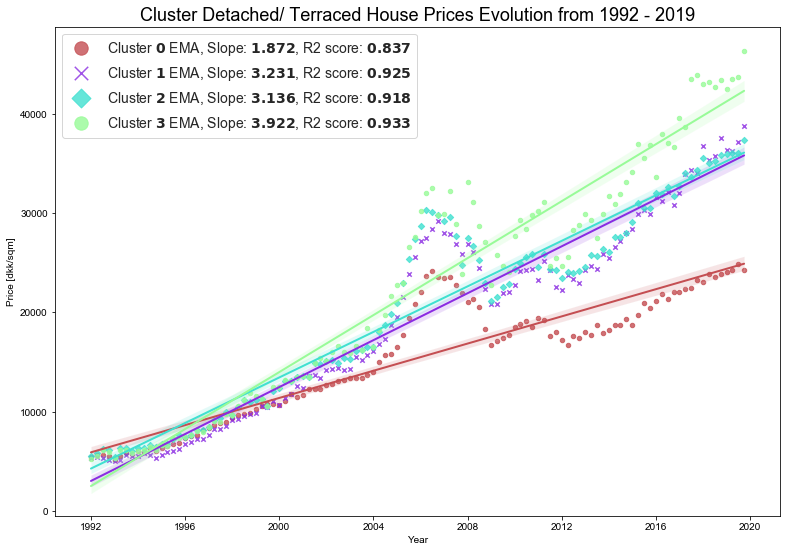

In [18]:

%matplotlib inline

fig1, ax11=plt.subplots(figsize=(13, 9))

sns.set(font_scale=1.5)
sns.set_style('whitegrid')
label0= 'Cluster '+ r'$\bf{0}$ EMA, Slope: '+ r'$\bf{'+ coef[0]+ '}$' + ', R2 score: '+ r'$\bf{'+ R2_Score[0]+ '}$'
label1= 'Cluster '+ r'$\bf{1}$ EMA, Slope: '+ r'$\bf{'+ coef[1]+ '}$' + ', R2 score: '+ r'$\bf{'+ R2_Score[1]+ '}$'
label2= 'Cluster '+ r'$\bf{2}$ EMA, Slope: '+ r'$\bf{'+ coef[2]+ '}$' + ', R2 score: '+ r'$\bf{'+ R2_Score[2]+ '}$'
label3= 'Cluster '+ r'$\bf{3}$ EMA, Slope: '+ r'$\bf{'+ coef[3]+ '}$' + ', R2 score: '+ r'$\bf{'+ R2_Score[3]+ '}$'


ax11=sns.regplot(x=House_df_grouped0T['Dat2Num'], y= House_df_grouped0T['Detached/terraced house'],data=House_df_grouped0T,label=label0, scatter_kws={'s': 20,'color': 'r'}, line_kws={'lw': 2, 'color': 'r'})
ax1=sns.regplot(x=House_df_grouped1T['Dat2Num'], y= House_df_grouped1T['Detached/terraced house'],data=House_df_grouped1T,label=label1, scatter_kws={'s': 20,'color': 'blueviolet'}, line_kws={'lw': 2, 'color': 'blueviolet'}, marker= 'x')
ax2=sns.regplot(x=House_df_grouped2T['Dat2Num'], y= House_df_grouped2T['Detached/terraced house'],data=House_df_grouped2T, label=label2,scatter_kws={'s': 20,'color': 'turquoise'},  line_kws={'lw': 2, 'color': 'turquoise'}, marker= 'D')
ax2=sns.regplot(x=House_df_grouped3T['Dat2Num'], y= House_df_grouped3T['Detached/terraced house'],data=House_df_grouped3T, label=label3,scatter_kws={'s': 20,'color': 'palegreen'},  line_kws={'lw': 2, 'color': 'palegreen'})

loc = mdates.AutoDateLocator()
ax11.xaxis.set_major_locator(loc)
ax11.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

ax11.set(xlabel='Year', ylabel='Price [dkk/sqm]')
ax11.set_title('Cluster Detached/ Terraced House Prices Evolution from 1992 - 2019')
ax11.legend(markerscale=3, loc=2, fontsize=14)
plt.savefig('Terraced House.pdf')



Sqaure meter price of detached/terraced house are increasing through time. 
House prices in all clusters start in a similar position (~6000 dkk) in 1992 then increase in homogeneous rates over the 10 years. Around 2004, prices started to expereience a boom, especially, Cluster 3 which has the highest increase rate. The accelerated increase continues till 2007  where the prices starts to dive. After 4 years of price fluctuations, the price recover its initial increase rate which continues till end of 2019. 
Through years, cluster 4 has the highest Sqaure meter price of detached/terraced house (with a slope of 3.922) whereas houses in cluster 0 has continously the lowest Sqaure meter price of detached/terraced house. Cluster 1 and 2 house prices witness almost identical increase rates (3.231 and 3.136 respectively) over the same period of time with the cluster 2 having slightly higher prices to cluster 1 untill 2019 where Cluster 2 registers higher sales price. 
Accuracy of the linear models are very good with the highest R2 score at 0.933. 


# 4.2 Flat Price Regression Analysis 
now let's apply the same method we have on sec 4.1 to flat prices. 

In [19]:
groupedT=(House_df_grouped0T,House_df_grouped1T,House_df_grouped2T,House_df_grouped3T)

Owner_R2_Score=list()
Owner_coef = list() 

for group in groupedT: #build linear regression model and fit it to the data and get the r2 score and coefficint
    lm = linear_model.LinearRegression()
    X= np.array(list(group['Dat2Num'])).reshape(-1, 1)
    y=list(group['Owner-occupied flat'])
    model = lm.fit(X,y)
    R2=lm.score(X,y)
    Owner_R2_Score.append(R2)
    Owner_coef.append(lm.coef_)
Owner_coef=[l.tolist() for l in Owner_coef]
import itertools
Owner_coef = list(itertools.chain.from_iterable(Owner_coef))
Owner_R2_Score = [round(num,3) for num in Owner_R2_Score]
Owner_R2_Score = [str(num) for num in Owner_R2_Score]

Owner_coef = [round(num,3) for num in Owner_coef]
Owner_coef = [str(num) for num in Owner_coef]




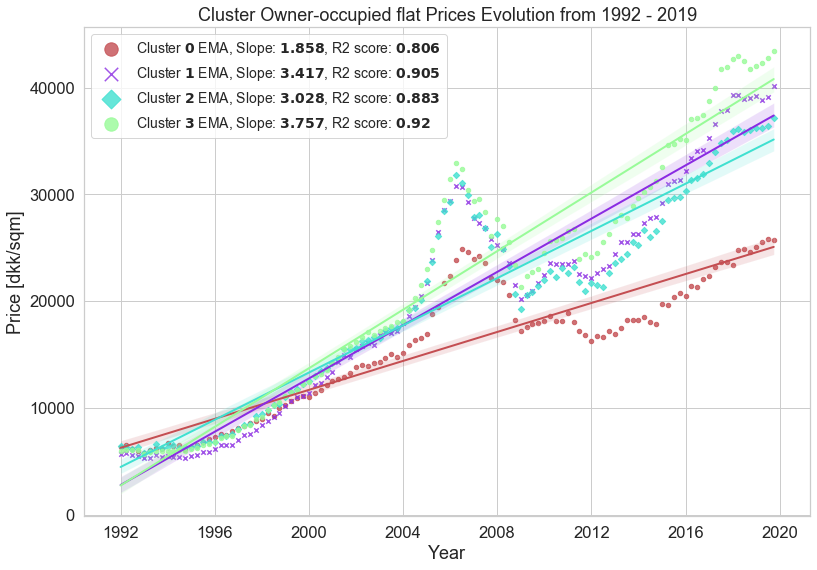

In [20]:
%matplotlib inline

fig2, ax22=plt.subplots(figsize=(13, 9))
#ax22.figure()

sns.set(font_scale=1.5)
sns.set_style('whitegrid')

label0= 'Cluster '+ r'$\bf{0}$ EMA, Slope: '+ r'$\bf{'+ Owner_coef[0]+ '}$' + ', R2 score: '+ r'$\bf{'+ Owner_R2_Score[0]+ '}$'
label1= 'Cluster '+ r'$\bf{1}$ EMA, Slope: '+ r'$\bf{'+ Owner_coef[1]+ '}$' + ', R2 score: '+ r'$\bf{'+ Owner_R2_Score[1]+ '}$'
label2= 'Cluster '+ r'$\bf{2}$ EMA, Slope: '+ r'$\bf{'+ Owner_coef[2]+ '}$' + ', R2 score: '+ r'$\bf{'+ Owner_R2_Score[2]+ '}$'
label3= 'Cluster '+ r'$\bf{3}$ EMA, Slope: '+ r'$\bf{'+ Owner_coef[3]+ '}$' + ', R2 score: '+ r'$\bf{'+ Owner_R2_Score[3]+ '}$'


ax=sns.regplot(x=House_df_grouped0T['Dat2Num'], y= House_df_grouped0T['Owner-occupied flat'],data=House_df_grouped0T,label=label0, scatter_kws={'s': 20,'color': 'r'},  line_kws={'lw': 2, 'color': 'r'})
ax1=sns.regplot(x=House_df_grouped1T['Dat2Num'], y= House_df_grouped1T['Owner-occupied flat'],data=House_df_grouped1T,label=label1, scatter_kws={'s': 20, 'color': 'blueviolet'},  line_kws={'lw': 2, 'color': 'blueviolet'}, marker= 'x')
ax2=sns.regplot(x=House_df_grouped2T['Dat2Num'], y= House_df_grouped2T['Owner-occupied flat'],data=House_df_grouped2T, label=label2,scatter_kws={'s': 20,'color': 'turquoise'},  line_kws={'lw': 2, 'color': 'turquoise'}, marker= 'D')
ax2=sns.regplot(x=House_df_grouped3T['Dat2Num'], y= House_df_grouped3T['Owner-occupied flat'],data=House_df_grouped3T, label=label3,scatter_kws={'s': 20,'color': 'palegreen'},  line_kws={'lw': 2, 'color': 'palegreen'})
loc = mdates.AutoDateLocator()
ax22.xaxis.set_major_locator(loc)
ax22.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

ax22.set(xlabel='Year', ylabel='Price [dkk/sqm]')
ax22.set_title('Cluster Owner-occupied flat Prices Evolution from 1992 - 2019')
ax22.legend(markerscale=3, loc=2, fontsize=14)
#plt.savefig('Owner-occupied flat.pdf')



Similar to house prices, sqaure meter price of owner occupied flats has also increased through time. flat prices in all clusters start in a similar position (~6000 dkk) in 1992 then increase in homogeneous rates over the 12 years. Meanwhile, cluster 2 flat prices have experienced lower increase rates that leads to a price gap being created between cluster 2 and the other clusters in 2002.  Around 2004, prices started to expereience a boom, again, cluster 0,1 and 3 have higher increase rates in comparision to cluster 2.

The accelerated increase continues till 2007 where the prices took a long dive. It is only till 2012 that flat price recover its uptrend which continues till end of 2019. 

Through years, cluster 3 has the highest Sqaure meter price of owner occupied flats (with a slope of 3.757) whereas houses in cluster 0 has continously the lowest Sqaure meter price. Cluster 1 and 2 house prices witness almost high increase rates (3.417 and 3.028 respectively) over the same period of time with the cluster 2 having slightly higher prices to cluster 1 untill 2010 where Cluster 1 registers higher sales price. 

Linear models have high accuracy scores with the highest R2 score at 0.92 for cluster 3 model.

# 4.3 Comparing the two figures 


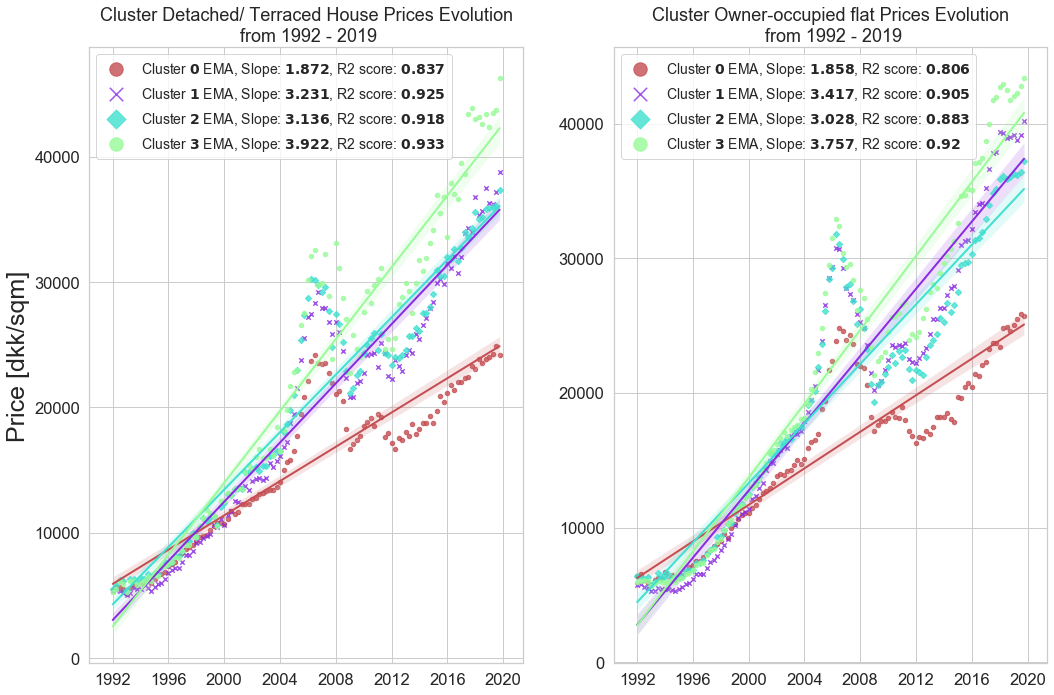

In [21]:
%matplotlib inline

fig, (axes1,axes2) = plt.subplots(1,2, figsize=(15, 10))
axes1.set_ylabel('Price', fontsize=25)


sns.set(font_scale=1.5)
sns.set_style('whitegrid')
label0= 'Cluster '+ r'$\bf{0}$ EMA, Slope: '+ r'$\bf{'+ coef[0]+ '}$' + ', R2 score: '+ r'$\bf{'+ R2_Score[0]+ '}$'
label1= 'Cluster '+ r'$\bf{1}$ EMA, Slope: '+ r'$\bf{'+ coef[1]+ '}$' + ', R2 score: '+ r'$\bf{'+ R2_Score[1]+ '}$'
label2= 'Cluster '+ r'$\bf{2}$ EMA, Slope: '+ r'$\bf{'+ coef[2]+ '}$' + ', R2 score: '+ r'$\bf{'+ R2_Score[2]+ '}$'
label3= 'Cluster '+ r'$\bf{3}$ EMA, Slope: '+ r'$\bf{'+ coef[3]+ '}$' + ', R2 score: '+ r'$\bf{'+ R2_Score[3]+ '}$'


axes1= sns.regplot(x=House_df_grouped0T['Dat2Num'], y= House_df_grouped0T['Detached/terraced house'],data=House_df_grouped0T,label=label0, scatter_kws={'s': 20,'color': 'r'}, line_kws={'lw': 2, 'color': 'r'}, ax=axes1)
ax1=sns.regplot(x=House_df_grouped1T['Dat2Num'], y= House_df_grouped1T['Detached/terraced house'],data=House_df_grouped1T,label=label1, scatter_kws={'s': 20,'color': 'blueviolet'}, line_kws={'lw': 2, 'color': 'blueviolet'}, marker= 'x', ax=axes1)
ax2=sns.regplot(x=House_df_grouped2T['Dat2Num'], y= House_df_grouped2T['Detached/terraced house'],data=House_df_grouped2T, label=label2,scatter_kws={'s': 20,'color': 'turquoise'},  line_kws={'lw': 2, 'color': 'turquoise'}, marker= 'D',ax=axes1)
ax2=sns.regplot(x=House_df_grouped3T['Dat2Num'], y= House_df_grouped3T['Detached/terraced house'],data=House_df_grouped3T, label=label3,scatter_kws={'s': 20,'color': 'palegreen'},  line_kws={'lw': 2, 'color': 'palegreen'},ax=axes1)

loc = mdates.AutoDateLocator()
axes1.xaxis.set_major_locator(loc)
axes1.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

axes1.set(xlabel='', ylabel='Price [dkk/sqm]')
axes1.set_title('Cluster Detached/ Terraced House Prices Evolution\n from 1992 - 2019')
axes1.legend(markerscale=3, loc=2, fontsize=14)



sns.set(font_scale=1.5)
sns.set_style('whitegrid')

label0= 'Cluster '+ r'$\bf{0}$ EMA, Slope: '+ r'$\bf{'+ Owner_coef[0]+ '}$' + ', R2 score: '+ r'$\bf{'+ Owner_R2_Score[0]+ '}$'
label1= 'Cluster '+ r'$\bf{1}$ EMA, Slope: '+ r'$\bf{'+ Owner_coef[1]+ '}$' + ', R2 score: '+ r'$\bf{'+ Owner_R2_Score[1]+ '}$'
label2= 'Cluster '+ r'$\bf{2}$ EMA, Slope: '+ r'$\bf{'+ Owner_coef[2]+ '}$' + ', R2 score: '+ r'$\bf{'+ Owner_R2_Score[2]+ '}$'
label3= 'Cluster '+ r'$\bf{3}$ EMA, Slope: '+ r'$\bf{'+ Owner_coef[3]+ '}$' + ', R2 score: '+ r'$\bf{'+ Owner_R2_Score[3]+ '}$'


axes2=sns.regplot(x=House_df_grouped0T['Dat2Num'], y= House_df_grouped0T['Owner-occupied flat'],data=House_df_grouped0T,label=label0, scatter_kws={'s': 20,'color': 'r'},  line_kws={'lw': 2, 'color': 'r'}, ax=axes2)
ax1=sns.regplot(x=House_df_grouped1T['Dat2Num'], y= House_df_grouped1T['Owner-occupied flat'],data=House_df_grouped1T,label=label1, scatter_kws={'s': 20, 'color': 'blueviolet'},  line_kws={'lw': 2, 'color': 'blueviolet'}, marker= 'x')
ax2=sns.regplot(x=House_df_grouped2T['Dat2Num'], y= House_df_grouped2T['Owner-occupied flat'],data=House_df_grouped2T, label=label2,scatter_kws={'s': 20,'color': 'turquoise'},  line_kws={'lw': 2, 'color': 'turquoise'}, marker= 'D')
ax2=sns.regplot(x=House_df_grouped3T['Dat2Num'], y= House_df_grouped3T['Owner-occupied flat'],data=House_df_grouped3T, label=label3,scatter_kws={'s': 20,'color': 'palegreen'},  line_kws={'lw': 2, 'color': 'palegreen'})
loc = mdates.AutoDateLocator()
axes2.xaxis.set_major_locator(loc)
axes2.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

axes2.set(xlabel='', ylabel='')
axes2.set_title('Cluster Owner-occupied flat Prices Evolution\n from 1992 - 2019')
axes2.legend(markerscale=3, loc=2, fontsize=14)

fig.tight_layout()



# 5 Results

- Across all clusters, house value appreciate in higher rates to flat value in the same commune (difference in slope 0.1-0.2).
- House and flats located in Cluster 0 communes,  (labelled as underdeveloped areas in the first article), have distinguishingly lower square meter price and lower price appreciation rates to their counterparts in other communes.
- Contrary to house and flats located in Cluster 3 communes (Copenhagen and Frederiksberg municipalities) which have the highest value and the best appreciation rates.
- In recent years, both flat and house prices in Cluster 1 registered higher selling prices compared to Cluster 2.

# 6 Discussion

Granular dataset enables me addressing high level questions. 
Through the analysis, communes in cluster 3 (Residence and College & University) witness the best apperciation rates. Also, we've seen that houses has the most significant price appreciation through the year in Copenhagen over flats in the same communes. 

Yet, to be objective, shortcomings have surfaced late in the analysis, the ones I captured are the following:
- some communes are part of all clusters duplicates (like Copenhagen and Frederiksberg municipalities) which have hinder the relevance of the inter-cluster analysis. I mitigate that choosing the median of the group.
- Cluster 1 and 3 contain relatively low statistical sample of communes.
- Property dataset ignore the characteristics of the sold property, its location and many other key parameters which play key role in the property selling price. I had one number summing up the property sqm price per commune over year quarter.
- Taking the median of the cluster took a substantial part of the dataset. Modes would also provide a good indication.

# 7 FUTURE DIRECTIONS

-  Results could be combined with factors determining house prices (e.g. interest rates, economic growth, number of households, speculative demand, new builds, supply of housing , numbering selling) to provide a context to how different communes re-acts to the change in factors.
 
# 8 CONCLUSIONS

Although buying a property as a primary residence or an investement is very dependant on each individual property features, however, on a granular base, buying a house in either Copenhagen and Frederiksberg municipalities seems to be the best investement.  